<a href="https://colab.research.google.com/github/JensLe97/tech_knowl_edge_connect/blob/main/scripts/tech_knowl_edge_connect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TechKnowlEdgeConnect Data Analysis and Generation

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
data_path = '/content/gdrive/MyDrive/tech_knowl_edge_connect/data'

Mounted at /content/gdrive


In [2]:
!pip3 install torch torchvision torchaudio

In [3]:
!pip install portalocker torchdata

In [29]:
%matplotlib inline

## CNN model on MNIST
Based on https://colab.research.google.com/github/omarsar/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [26]:
print(torch.__version__)

2.2.1+cu121


In [27]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root=data_path, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root=data_path, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

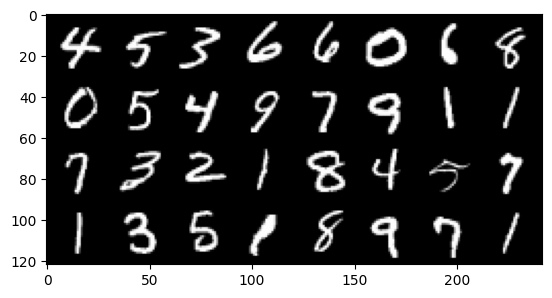

In [28]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [30]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [31]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [32]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)

    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.6183 | Train Accuracy: 84.79
Epoch: 1 | Loss: 1.5211 | Train Accuracy: 94.30
Epoch: 2 | Loss: 1.4844 | Train Accuracy: 97.93
Epoch: 3 | Loss: 1.4797 | Train Accuracy: 98.38
Epoch: 4 | Loss: 1.4763 | Train Accuracy: 98.67


In [33]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.24


## Transformer Network
Sequence-to-sequence model on Wikitext-2 dataset from torchtext based on https://pytorch-tutorials-preview.netlify.app/beginner/transformer_tutorial.html

In [4]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [17]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

In [14]:
from torchtext.datasets import PennTreebank
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = PennTreebank(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = PennTreebank()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [9]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [18]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [19]:
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [20]:
best_val_loss = float('inf')
epochs = 3

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 1320 batches | lr 5.00 | ms/batch 292.17 | loss  7.22 | ppl  1370.00
| epoch   1 |   400/ 1320 batches | lr 5.00 | ms/batch 295.98 | loss  6.10 | ppl   447.89
| epoch   1 |   600/ 1320 batches | lr 5.00 | ms/batch 297.48 | loss  5.88 | ppl   356.70
| epoch   1 |   800/ 1320 batches | lr 5.00 | ms/batch 289.69 | loss  5.70 | ppl   299.40
| epoch   1 |  1000/ 1320 batches | lr 5.00 | ms/batch 283.61 | loss  5.64 | ppl   281.54
| epoch   1 |  1200/ 1320 batches | lr 5.00 | ms/batch 284.74 | loss  5.54 | ppl   254.17
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 391.65s | valid loss  5.57 | valid ppl   261.29
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1320 batches | lr 4.75 | ms/batch 281.99 | loss  5.47 | ppl   237.45
| epoch   2 |   400/ 1320 batches | lr 4.75 | ms/batch 280.84 | loss  5.40 | ppl   222.39
| epoch   2 |   600/ 1320

In [21]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.36 | test ppl   212.14
